# 1. Deep Learning

## 1.1 Preparazione del notebook

Premere il tasto *play* della cella seguente per importare i dataset dalla repository di GitHub.

In [ ]:
! git clone https://github.com/vitoreno/StelleDataset.git
! unzip /content/StelleDataset/data.zip

Premere il tasto *play* della cella seguente per importare le librerie necessarie all'esecuzione del notebook.

In [2]:
%load_ext google.colab.data_table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler

## 1.2 Neural Network

Si intende predire i valori di umidità del suolo sulla costa a partire dalle temperature del mare nei punti più vicini, tramite una rete neurale.

L'architettura della rete è molto semplice e prevede la presenza di due livelli nascosti con dimensione di 8 e 16 neuroni. La rete viene addestrata con batch di dimensione 100 per 5 epoche.

Selezionare le regioni sulle quali effettuare il training, e quelle sulle quali effettuare la valutazione in una determinata data. Le date possibili vanno dal 2016-01-01 al 2016-12-31. Infine premere il tasto play per avviare l'esecuzione della cella.

Epoch 1/5
597/597 [==============================] - 1s 970us/step - loss: 0.0132
Epoch 2/5
597/597 [==============================] - 1s 884us/step - loss: 0.0040
Epoch 3/5
597/597 [==============================] - 1s 941us/step - loss: 0.0040
Epoch 4/5
597/597 [==============================] - 1s 884us/step - loss: 0.0040
Epoch 5/5
597/597 [==============================] - 1s 877us/step - loss: 0.0040


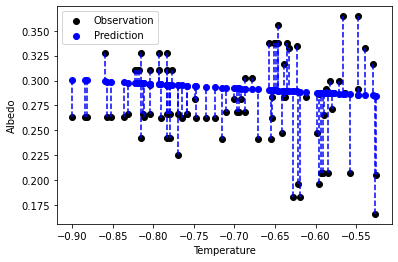

Mean Squared Error:  0.00197394164579254


,Observed albedo,Predicted albedo,Error
0,0.281488,0.294437,0.012949
1,0.281488,0.292380,0.010892
2,0.281488,0.291988,0.010500
3,0.283892,0.289637,0.005745
4,0.283892,0.288560,0.004668
...,...,...,...
85,0.311071,0.296298,0.014773
86,0.327889,0.295906,0.031983
87,0.295266,0.296787,0.001521
88,0.327889,0.297277,0.030611


In [3]:
#@markdown Training
train_Adriatic = True #@param {type:"boolean"}
train_Ionian = True #@param {type:"boolean"}
train_Tyrrhenian = False #@param {type:"boolean"}
train_Labrador = False #@param {type:"boolean"}
train_Red = False #@param {type:"boolean"}
#@markdown Test
date_str = '2016-01-01' #@param {type:"date"}
test_Adriatic = False #@param {type:"boolean"}
test_Ionian = False #@param {type:"boolean"}
test_Tyrrhenian = True #@param {type:"boolean"}
test_Labrador = False #@param {type:"boolean"}
test_Red = False #@param {type:"boolean"}

train_list = []
test_list = []
if train_Adriatic:
  train_list = train_list + ["Adriatic"]
if train_Ionian:
  train_list = train_list + ["Ionian"]
if train_Tyrrhenian:
  train_list = train_list + ["Tyrrhenian"]
if train_Labrador:
  train_list = train_list + ["Labrador"]
if test_Red:
  test_list = test_list + ["Red"]
if test_Adriatic:
  test_list = test_list + ["Adriatic"]
if test_Ionian:
  test_list = test_list + ["Ionian"]
if test_Tyrrhenian:
  test_list = test_list + ["Tyrrhenian"]
if test_Labrador:
  test_list = test_list + ["Labrador"]
if test_Red:
  test_list = test_list + ["Red"]

current_date = datetime.strptime(date_str + " 12:00:00", '%Y-%m-%d %H:%M:%S')

if (current_date < datetime.strptime("2016-01-01 12:00:00", '%Y-%m-%d %H:%M:%S')) | (current_date > datetime.strptime("2016-12-31 12:00:00", '%Y-%m-%d %H:%M:%S')):
  sys.exit("Data non valida. Inserire data compresa fra 2016-01-01 e 2016-12-31")

data = pd.read_csv("/content/soil_moisture_2016.csv")
data.time = pd.to_datetime(data.time)
train_data = data.loc[data['sea'].isin(train_list)]
test_data = data.loc[((data['sea'].isin(test_list)) & (data['time'] == current_date))]

train_sst = train_data.sst.to_numpy().reshape(-1, 1)
train_sm = train_data.sm.to_numpy()
test_sst = test_data.sst.to_numpy().reshape(-1, 1)
test_sm = test_data.sm.to_numpy()

# Feature scaling
sc = StandardScaler()
train_sst = sc.fit_transform(train_sst)
test_sst = sc.transform(test_sst)

# Model
model = Sequential()
model.add(Dense(8, activation = 'relu', input_dim = 1))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Training
model.fit(train_sst, train_sm, batch_size = 100, epochs = 5)

prediction = model.predict(test_sst).reshape(-1)

for i in range(test_sm.shape[0]):
  plt.plot([test_sst[i],test_sst[i]], [test_sm[i],prediction[i]], '--b')
plt.scatter(test_sst, test_sm, color='black', label='Observation')
plt.scatter(test_sst, prediction, color='blue', label='Prediction')
plt.xlabel('Temperature')
plt.ylabel('Albedo')
plt.legend()
plt.show()

results = pd.DataFrame({"Observed albedo": test_sm, "Predicted albedo": prediction, "Error": np.abs(test_sm - prediction)})
print("Mean Squared Error: ", mean_squared_error(test_sm, prediction))
results